## Getting Embeddings

In [252]:
# import the necessary packages
from imutils import paths
import numpy as np
import imutils
import cv2
import os
import model as embedding
import torch
import pickle

from facenet_pytorch import MTCNN
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [253]:
# face detection model
mtcnn = MTCNN(image_size=160)

# load embedding model
embedder = embedding.InceptionResnetV1(pretrained='vggface2').eval()

# paths to save pickle files
currentDir = os.getcwd()

# images folder
dataset = os.path.join(currentDir, "dataset")

# paths to save pickle files
embeddingPickle = os.path.join(currentDir, "output/FinalEmbeddings.pickle")

# getting all images paths
imagePaths = list(paths.list_images(dataset))

In [254]:
print("Total number of images ", len(imagePaths))

Total number of images  183


In [255]:
# create lists to append ImgPaths/names/imageIDs/boxs/embeddings
ImgPaths = []
names = []
imageIDs = []
boxs = []
embeddings = []

# initlize the total number of faces processed
total = 0

In [256]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    
    #extract the person name from the image path
    
    name = imagePath.split(os.path.sep)[-2]
    imageID = imagePath.split(os.path.sep)[-1].split('.')[-2]
    
    image = Image.open(imagePath)
    try:
        img_cropped = mtcnn.detect(image)
        box = img_cropped[0][0]
        box = box.astype('int')
    
        face = mtcnn(image)
    except:
        print("[Error] : ", imagePath)
    
    faceEmbed = embedder(face.unsqueeze(0))
    flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
    
    ImgPaths.append(imagePath)
    imageIDs.append(imageID)
    names.append(name)
    boxs.append(box)
    embeddings.append(flattenEmbed)
    total += 1

# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings ....".format(total))
data = {"paths":ImgPaths, "names":names, "imageIDs":imageIDs, "boxs":boxs, "embeddings":embeddings}
f = open(embeddingPickle , "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] serializing 183 encodings ....


## Train Model

In [257]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [258]:
# paths to embedding pickle file
embeddingPickle = "./output/FinalEmbeddings.pickle"

# path to recognizer pickle file
recognizerPickle = "./output/FinalRecognizer.pickle"

# path to labels pickle file
labelPickle = "./output/FinalLabel.pickle"

In [259]:
# loading embeddings pickle
data = pickle.loads(open(embeddingPickle, "rb").read())

# encode the labels
label = LabelEncoder()
labels = label.fit_transform(data["names"])

# getting embeddings
Embeddings = np.array(data["embeddings"])

In [260]:
print("Total number of embeddings : ", Embeddings.shape)
print("Total number of labels :", len(labels))

Total number of embeddings :  (183, 512)
Total number of labels : 183


#### Hyper-parameter tuning

In [261]:
X_train, X_test, y_train, y_test = train_test_split(
    Embeddings, labels, test_size=0.2, random_state=0)

In [262]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(146, 512)
(37, 512)
(146,)
(37,)


#### SVC

In [263]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [264]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.023 (+/-0.099) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.023 (+/-0.099) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.023 (+/-0.099) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.023 (+/-0.099) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.213 (+/-0.169) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.023 (+/-0.099) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.914 (+/-0.064) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.213 (+/-0.169) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.897 (+/-0.088) for {'C': 1, 'kernel': 'linear'}
0.914 (+/-0.064) for {'C': 10, 'kernel': 'linear'}
0.914 (+/-0.064) for {'C': 100, 'kernel': 'linear'}
0.914 (+/-0.064) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed

In [283]:
# train the model used to accept the 512-d embeddings of the face and 
# then produce the actual face recognition

#recognizer = KNeighborsClassifier(n_neighbors= 5, metric='euclidean', weights="distance")
recognizer = SVC(probability=True , C=1000, gamma=0.001 , kernel='rbf')
recognizer.fit(Embeddings, labels)

# write the actual face recognition model to disk
f = open(recognizerPickle, "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open(labelPickle,"wb")
f.write(pickle.dumps(label))
f.close()

### Recognize

In [284]:
import numpy as np
import pickle
import cv2
import os
import model as embedding
from imutils import paths
import imutils
import argparse
import torch

import os
import argparse
import torch
import numpy as np
import torch.backends.cudnn as cudnn

from models.retinaface.config import cfg
from models.retinaface.prior_box import PriorBox
from models.retinaface.py_cpu_nms import py_cpu_nms

import cv2

from models.retinaface.retinaface import RetinaFace
from models.retinaface.box_utils import decode , decode_landm
import time

                    
import torchvision.transforms.functional as F
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [285]:
# paths to embedding pickle file
embeddingPickle = "./output/FinalEmbeddings.pickle"

# path to recognizer pickle file
recognizerPickle = "./output/FinalRecognizer.pickle"

# path to labels pickle file
labelPickle = "./output/FinalLabel.pickle"

predictedImg = "./predictedImg"

In [286]:
trained_model_path = "models/retinaface/weights/Final_Retinaface.pth"
cpu = True
confidence_threshold = 0.05
top_k = 5000
nms_threshold = 0.3
keep_top_k = 750
save_image_path = "predictedImg"
vis_threshold = 0.6

In [287]:
### check_keys

def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

### remove_prefix
def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


### load_model
def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [288]:
torch.set_grad_enabled(False)

#net and model
net = RetinaFace(phase="test")
net = load_model(net , trained_model_path, cpu)
net.eval()
print("Finished loading model!")
cudnn.benchmark = True
device = torch.device("cpu" if cpu else "cuda")
net = net.to(device)

Loading pretrained model from models/retinaface/weights/Final_Retinaface.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!


In [289]:
resize = 1

In [290]:
# load embedding model
embedder = embedding.InceptionResnetV1(pretrained="vggface2").eval()

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(recognizerPickle, "rb").read())
label = pickle.loads(open(labelPickle, "rb").read())
# loading embeddings pickle
data = pickle.loads(open(embeddingPickle, "rb").read())

COLORS = np.random.randint(0, 255, size=(len(label.classes_), 3), dtype="uint8")

In [291]:
Embeddings = np.array(data["embeddings"])
names = np.array(data["names"])
print("Embeddings ", Embeddings.shape)
print("Names ", names.shape)
print("Labels ", labels.shape)

Embeddings  (183, 512)
Names  (183,)
Labels  (183,)


In [292]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [293]:
image_path = "prab.jpg"
save_image = True

In [294]:
def predectclass(path):
    image_path = path
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    imageName = image_path.split('/')[-1].split('.')[-2]

    img = np.float32(img_raw)

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)

    tic = time.time()
    loc, conf, landms = net(img)  # forward pass
    print('net forward time: {:.4f}'.format(time.time() - tic))

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                   img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                   img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)

    # show image
    if save_image:
                for b in dets:
                    if b[4] < vis_threshold:
                        continue
                    boxes = np.array(b[0:4])
                    boxes = boxes.astype('int')

                    (startX , startY, endX, endY) = boxes

                    face = img_raw_rgb[startY:endY , startX:endX]

                    try:
                        #print("yes-1")
                        faceRead = Image.fromarray(face)
                        faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                        faceRead = F.to_tensor(faceRead)
                        #print("yes-2")
                    except:
                        print("[Error] - resizing face ")
                        continue
                    #print(faceRead.shape)

                    # getting embeddings for croped faces
                    faceEmbed = embedder(faceRead.unsqueeze(0))
                    flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                    #print(flattenEmbed.shape)

                    # predectiong class
                    array = np.array(flattenEmbed).reshape(1,-1)
                    # perform classification to recognize the face
                    preds = recognizer.predict_proba(array)[0]

                    j = np.argmax(preds)

                    proba = preds[j]
                    name = label.classes_[j]
                    #print(name)

                    result = np.where(names == name)
                    resultEmbeddings = Embeddings[result]

                    dists = []
                    for emb in resultEmbeddings:
                        d = distance(emb, flattenEmbed)
                        dists.append(d)
                    #print(dists)
                    distarray = np.array(dists)
                    #print(distarray)
                    min_dist = np.min(distarray)
                    max_dist = np.max(distarray)
                    #print("Name : ",name)
                    #print("min dist : ",min_dist)
                    #print("max dist : ", max_dist)
                    
                    if proba >= 0.20:

                        if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.5):

                            #print("dist name ", name)
                            #print("min dist : ",min_dist)
                            #print("max dist : ", max_dist)


                            color = [int(c) for c in COLORS[j]]

                            cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                            text = "{}: {:.2f}".format(name, proba)
                            cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                        else:

                            name = "NONE"

                            color = (255, 255, 255)

                            cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                            text = "{}".format(name)
                            cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    else:

                        name = "NONE"

                        color = (255, 255, 255)

                        cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                        text = "{}".format(name)
                        cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


    # save image predicte foler
    cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)
    im = Image.open("{}/{}.png".format(predictedImg,imageName))
    return im                
               

net forward time: 0.1379


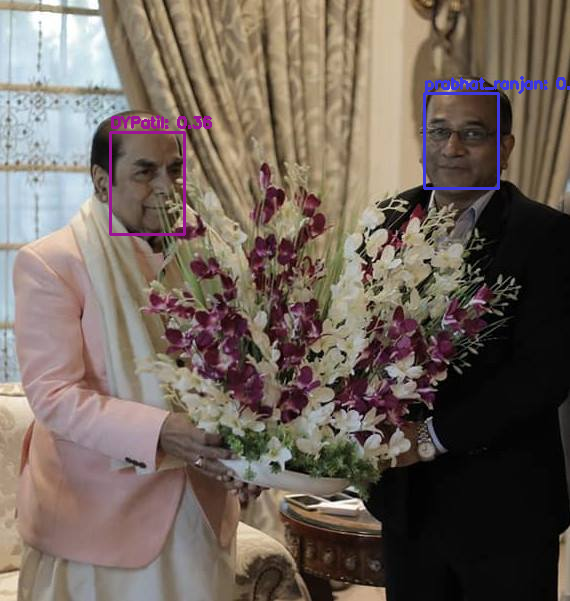

In [295]:
predectclass("ranjan/Prof Ranjan and DYP.jpg")

net forward time: 0.5081


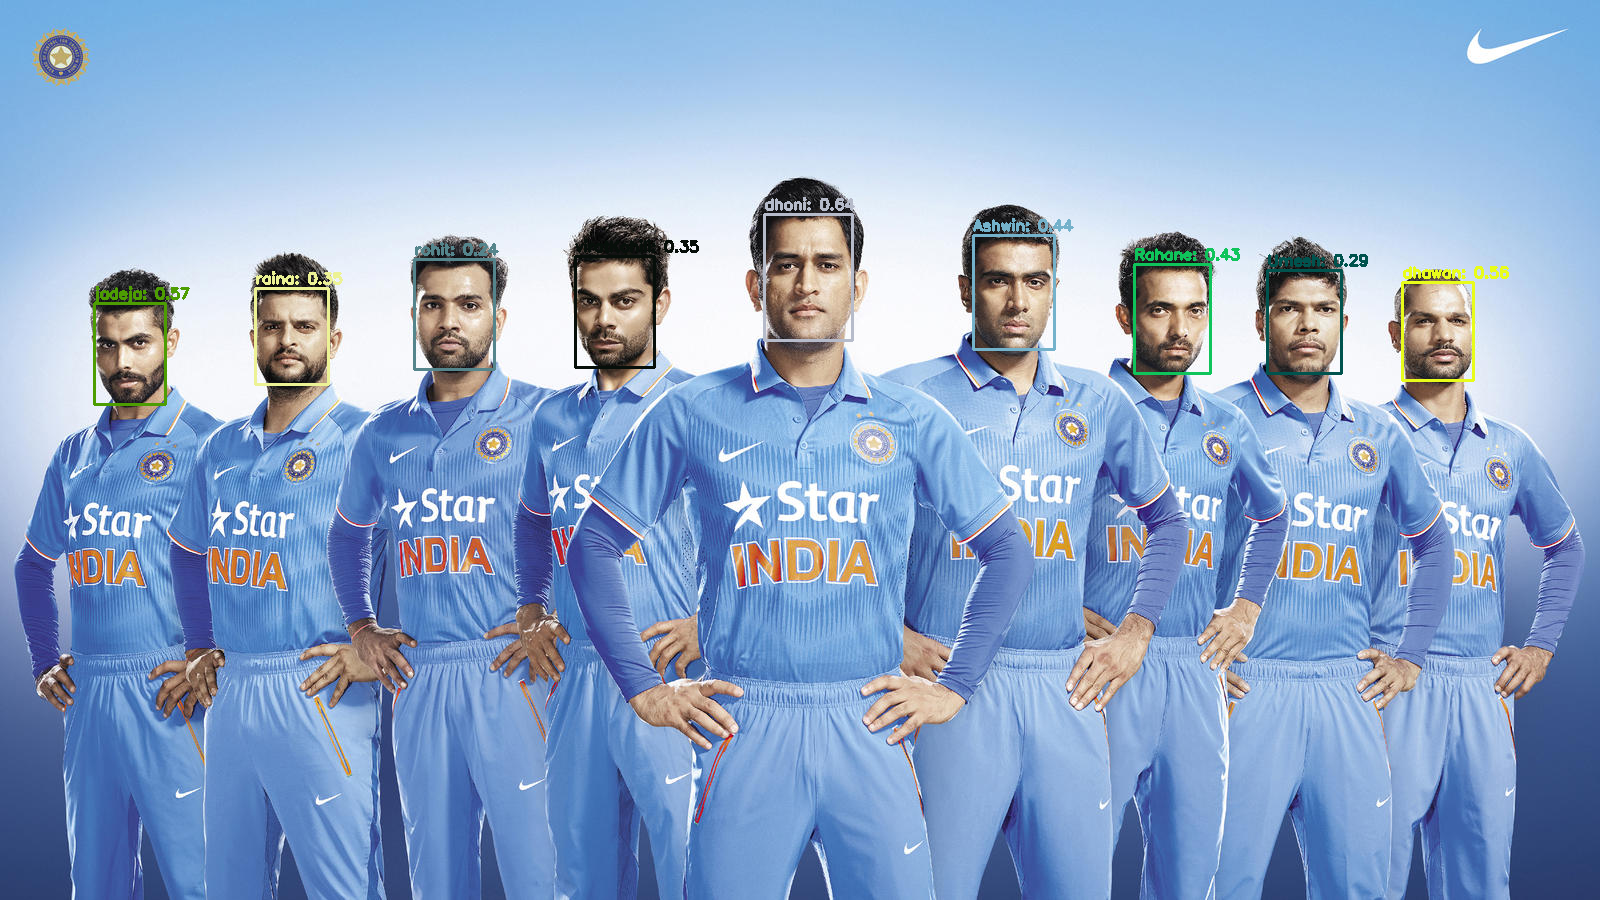

In [296]:
predectclass("indian_team.jpg")

net forward time: 0.2681


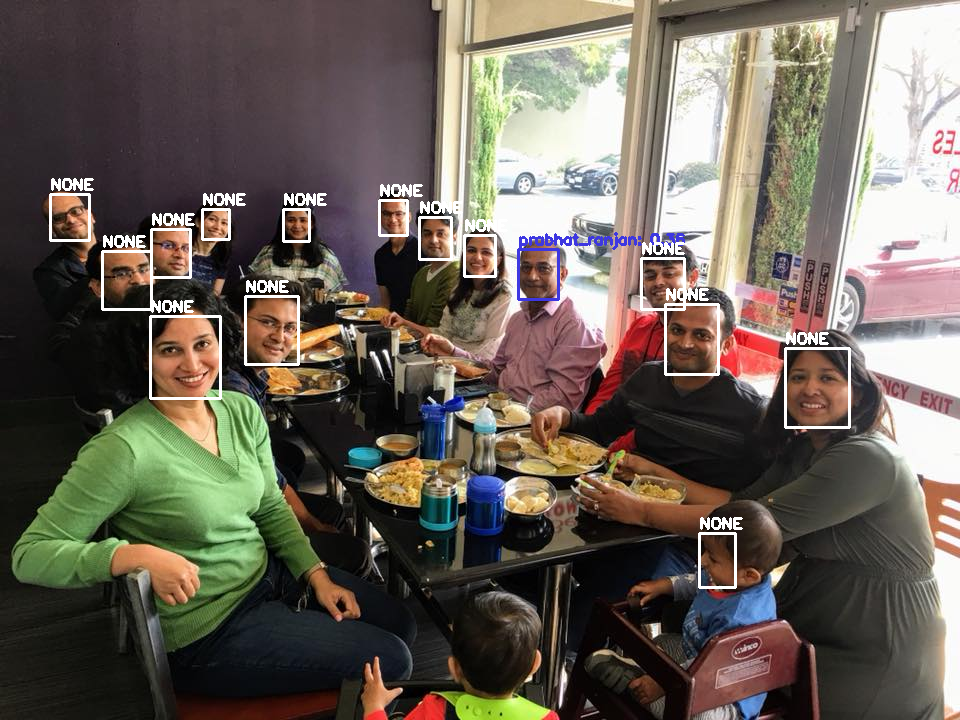

In [297]:
predectclass("ranjan/Prof Ranjan-5.jpg")

net forward time: 0.1948


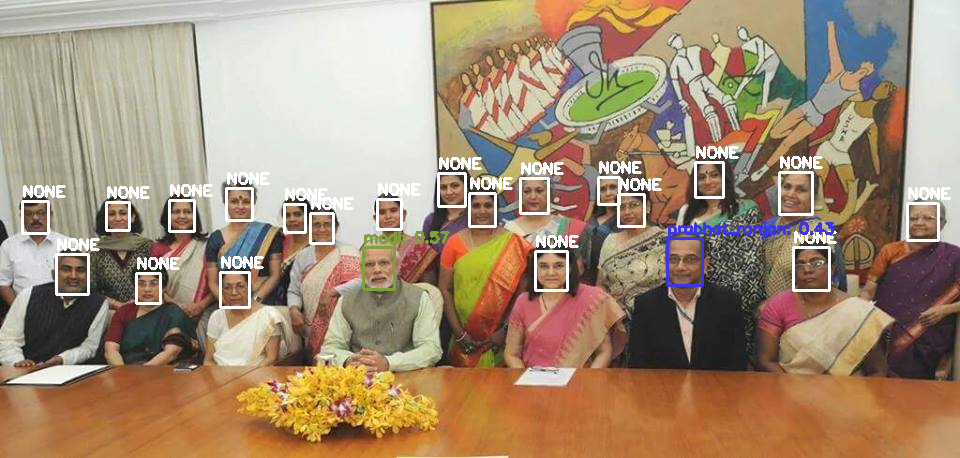

In [298]:
predectclass("prab.jpg")

net forward time: 0.2926


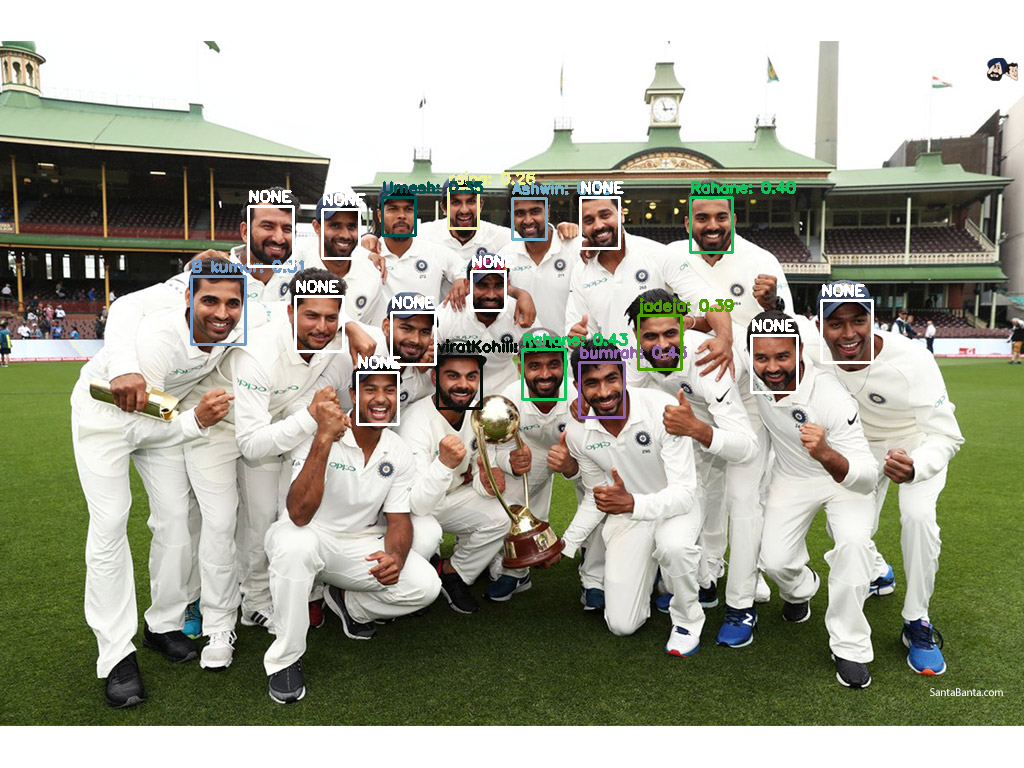

In [299]:
predectclass("IndianCricket/india-cricket-team-20a.jpg")

net forward time: 1.0712


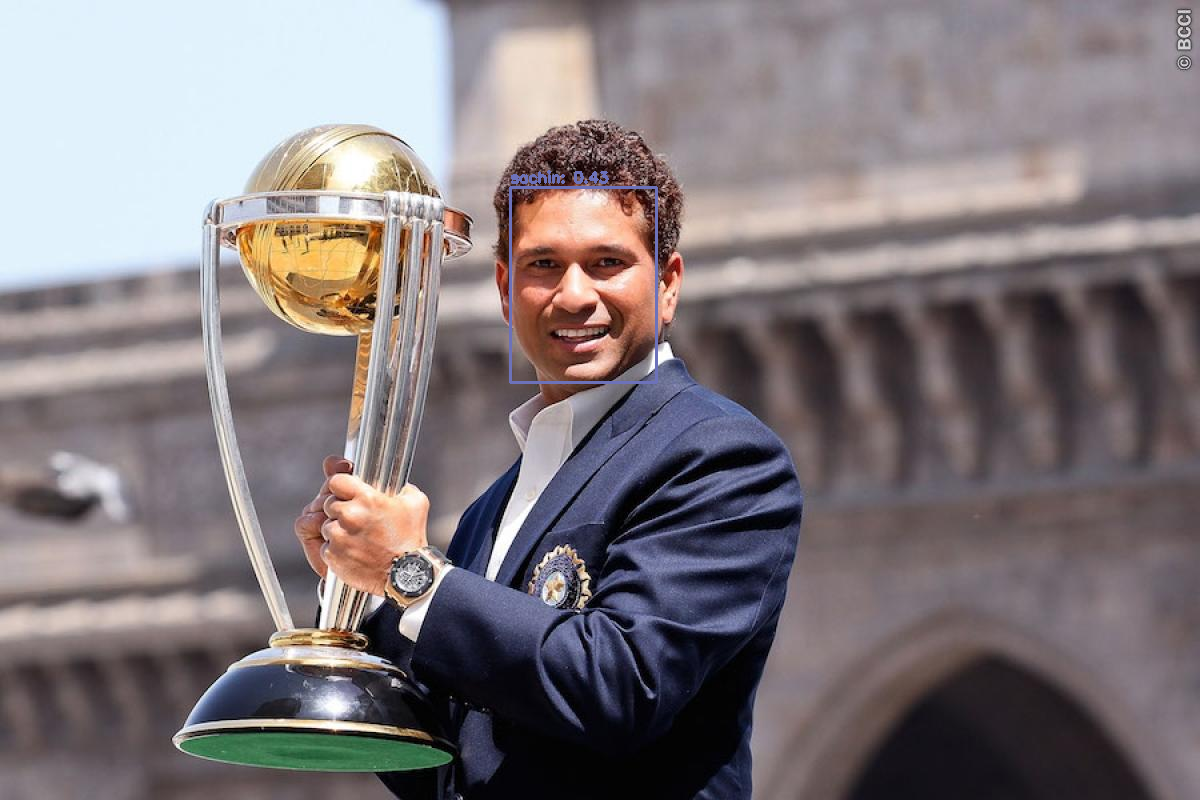

In [302]:
predectclass("IndianCricket/sachin.jpg")